In [67]:
import os
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from intcr.pipeline.utils import load_data
import pandas as pd
from intcr.data.tcr_titan import BLOSUM_IDX2KEY 
from anarci import anarci

In [68]:
resultsfolder = '/Users/wbr/Box/Molecular_SysBio/projects/HELICAL/Iliana_papadopoulou/paper/clustering_valid/explanations'

In [69]:
anchors = load_data(os.path.join(resultsfolder, 'anchors.pkl'))

In [70]:
def to_aa(tcr):
    sequence = []
    for idx in tcr:
        if BLOSUM_IDX2KEY[idx] != '<UNK>' and BLOSUM_IDX2KEY[idx] != '<START>' and BLOSUM_IDX2KEY[idx] != '<STOP>' and BLOSUM_IDX2KEY[idx] != '<PAD>':
            sequence.append(BLOSUM_IDX2KEY[idx])
    return ''.join(sequence)

In [71]:
def align(tcr):
    anarci_input = [("human1:TRB", tcr)]
    results = anarci(anarci_input, scheme="aho", output=False)
    numbering, alignment_details, hit_tables = results
    domain_numbering, start_index, end_index = numbering[0][0]
    aligned_seq = [tup[1] for tup in domain_numbering]
    # All sequences are right padded up to length 148
    while len(aligned_seq) < 148:
        aligned_seq.append('-')
    aligned_seq = ''.join(aligned_seq)

    # How were indices shifted?
    shift = [-3 for x in range(500-len(tcr)-2)] #shift all the padding to -1
    shift.append(-2) # Start token
    prior_pos = -1
    for aa in tcr:
        # first aa is at new position 0
        while aligned_seq[prior_pos+1] != aa:
            prior_pos+=1
        shift.append(prior_pos+1)
        prior_pos+=1
    shift.append(-1) # Stop token
    return aligned_seq, shift

In [72]:
REGIONS = {
    'Pad': (-3,-2),
    'Start': (-2,-1),
    'Stop': (-1,0),
    'FR1': (0,27),
    'CDR1': (27,43),
    'FR2': (43,51),
    'CDR2': (51,82),
    'FR3': (82,105),
    'CDR3': (105,139),
    'FR4': (139,147)
}

def anchors_per_region(explanation):
    regions = REGIONS.keys()
    anchors = []
    for medoid in explanation.keys():
        tcr = explanation[medoid].data['raw']['instance']
        rule_positions = explanation[medoid].data['raw']['feature']
        aligned_seq, shift = align(to_aa(tcr))
        # shift rule positions
        shifted_rule_positions = [shift[x] for x in rule_positions]
        assert aligned_seq[shifted_rule_positions[0]] == BLOSUM_IDX2KEY[tcr[rule_positions[0]]]
        # count nr of anchor rules per region
        nr_anchors = []
        for (lim_low, lim_high) in REGIONS.values():
            rules_in_region = [x for x in shifted_rule_positions if x < lim_high and x >= lim_low]
            nr_anchors.append(len(rules_in_region))
        anchors.append(nr_anchors)
    anchors_per_region = [np.sum(np.array(anchors)[:,x]) for x in range(len(regions))]
    return regions, anchors_per_region

In [73]:
binding = 1
regions, nr_anchors = anchors_per_region(anchors[binding])
nr_anchors, regions

([0, 1, 0, 6, 2, 0, 3, 9, 2, 2],
 dict_keys(['Pad', 'Start', 'Stop', 'FR1', 'CDR1', 'FR2', 'CDR2', 'FR3', 'CDR3', 'FR4']))

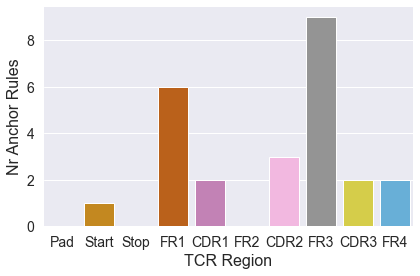

In [76]:
# actual plot
sns.set_theme() 
sns.set_palette("colorblind")
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False)
splot1 = sns.barplot(x=list(regions), y=nr_anchors)
splot1.yaxis.grid(True, clip_on=False)     
ax1.set_ylabel('Nr Anchor Rules',fontsize=16)
ax1.tick_params(labelsize=14)                                     
ax1.set_xlabel('TCR Region',fontsize=16)    
sns.despine(left=True, bottom=True)       
plt.tight_layout()
plt.savefig(os.path.join(resultsfolder, 'rules_per_region_'+str(binding)+'.pdf'))